# Welcome to the interactive Galaxy IPython Notebook.

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

# Comparing E. coli C assembly against other complete E. coli genomes

--------

In this notebook we process data generated by aligning our assembly against all fully sequenced *E. coli* genomes from NCBI. The alignemnt was computed in Galaxy and here we perform additional manipulations of these data.

### Configuring the environment

First it is necessary to install all libraries required for this analysis:


In [1]:
# Make sure cells are full width of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Install pandasql which will allow easily querying data
# Be patient: it may take several minutes
!pip install -U pandasql

Requirement already up-to-date: pandasql in /opt/conda/envs/python2/lib/python2.7/site-packages
Requirement already up-to-date: pandas in /opt/conda/envs/python2/lib/python2.7/site-packages (from pandasql)
Requirement already up-to-date: sqlalchemy in /opt/conda/envs/python2/lib/python2.7/site-packages (from pandasql)
Requirement already up-to-date: numpy in /opt/conda/envs/python2/lib/python2.7/site-packages (from pandasql)
Requirement already up-to-date: python-dateutil in /opt/conda/envs/python2/lib/python2.7/site-packages (from pandas->pandasql)
Requirement already up-to-date: pytz>=2011k in /opt/conda/envs/python2/lib/python2.7/site-packages (from pandas->pandasql)
Requirement already up-to-date: six>=1.5 in /opt/conda/envs/python2/lib/python2.7/site-packages (from python-dateutil->pandas->pandasql)


In [3]:
# xlrd will allow reading excel files directly
!pip install xlrd

In [4]:
# Import necessary Python libraries
import pandas as pd
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import numpy as np
import pylab as pl
from matplotlib import collections as mc
import matplotlib.ticker as ticker

### Getting data from Galaxy

The alignment between our assembly and all sequenced genomes is generated in Galaxy using its powerful compute infrastructure. It is generated with BLAST+ using the following parameters:

- **Type of BLAST** - `megablast`
- **Output format** - `Tabular (select which columns)`
    - **Standard columns** (only checked ones are listed below)
        - `length`
        - `qstart`
        - `qend`
        - `sstart`
        - `send`
    - **Extended columns** (only checked ones are listed below)
        - `qacc`
        - `sacc`
- **Advanced options** - `Show Advanced Options`
    - **Word size** - `32`

-----

To get data from Galaxy use `get(<history item number>)` command, where `<history item number>` corresponds to dataset number in Galaxy's history. For example, in this case this number is `9`:
           

In [5]:
# Here you get a dataset from Galaxy history.
# Make sure it has the right number!!!

get(9)

'/import/9'

In [6]:
# Give the file a meaningful name

!mv 9 blast.txt

In [7]:
mb = pd.read_table('blast.txt', header=None)

In [8]:
mb.columns = ['len','qstart','qend','tstart','tend','qlen','tlen','q','t']

In [9]:
mb.head()

,len,qstart,qend,tstart,tend,qlen,tlen,q,t
0,2809170,1,2809168,1,2809169,4576293,4625968,1,LT906474
1,1323489,3252807,4576293,3302485,4625968,4576293,4625968,1,LT906474
2,443656,2809157,3252812,2809125,3252780,4576293,4625968,1,LT906474
3,1432347,406431,1838776,406140,1838482,4576293,4617024,1,CP020543
4,1266578,3252807,4519381,3303410,4569981,4576293,4617024,1,CP020543


## Finding closely realated genomes

-------

First, let's see which E. coli genomes are most closely related to our assembly.

Now, using pysqldf module we will perform an SQL query on these data. In particular we will group the data on t (Target = name of the sequence we are aligning against) and compute the following metrics:

 - Number of alignments between our assemby and each target (count(*) as N)
 - Average nucleotide identity (avg(id) as av_id)
 - Total alignment length (sum(len) as tot_len)
 
The result will be stored in a new dataframe called best:

In [10]:
best = pysqldf("select t, count(*) as N, sum(len) as tot_len from mb group by t order by N asc limit 10")

What are the top targets having the highest homology to our assembly? Let's see:

In [11]:
pysqldf("select * from best where tot_len > 4000000 order by N asc")

,t,N,tot_len
0,LT906474,3,4576315
1,CP020543,7,4566128
2,CP024090,13,4539971
3,CP009166,81,4141841
4,CP010371,81,4085376
5,CP010152,84,4094361


Above you can see that the first three genomes (LT906474, CP020543, and CP024090) are most similar to ours, but this quickly deteriorates for other genomes with the number of alignemnts quickly increasing (N column). The following box plots show that. You can see that *N* is skewed towards high values: 

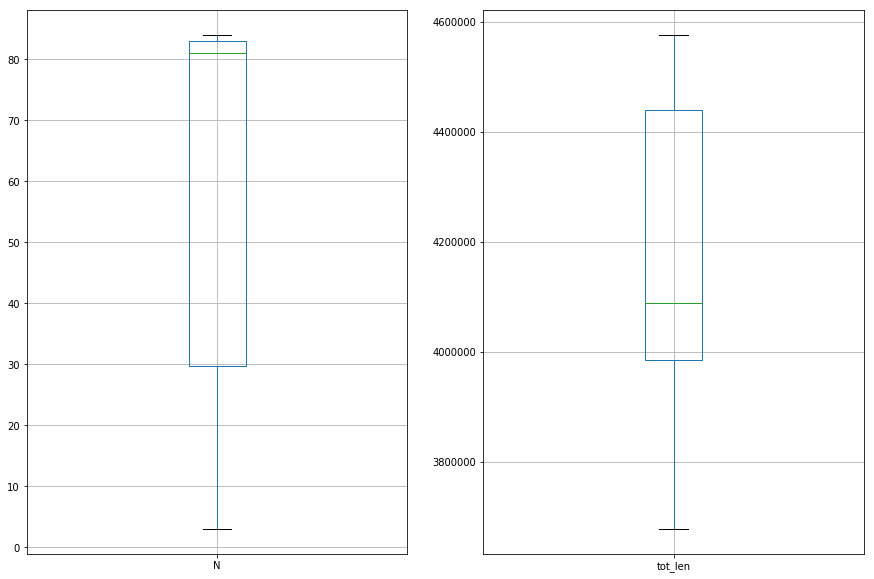

In [12]:
%matplotlib inline
best.plot.box(grid=True,subplots=True, figsize=(15, 10));

## Comparing genome architecture

------

Now we want to get a rough idea of how our genome compares with genomes of closely related E. coli strains. Are there rearrangements, duplications, etc?

So, based on previous calculations LT906474, CP020543 appear to be the most closely related genomes. First, we create an array containing their IDs:

In [13]:
top = ['LT906474','CP020543']

We will use coordinates of alignemnts produced by megablast and plot pairiwise relationship among these genomes (aka. dotplots). To do this we need to convert coordinates in the form of an array that looks like this:

`[[start in our genome, start in other E. coli], [end in our genome, end in other E. coli]]`

The following code accomplished this:

In [14]:
# For top accession number create a dictionary, where for each accession number
# There is a list of starts end ends for blast between our assembly and E. coli accessions

from collections import defaultdict
strain_data = defaultdict(list) 

for strain in top:
    coord = []
    for row in pysqldf(("select qstart,qend,tstart,tend from mb where t = '%s'") % ( strain )).values.tolist():
        coord.append( [[row[0],row[2]],[row[1],row[3]]] )
    strain_data[ strain ] = coord

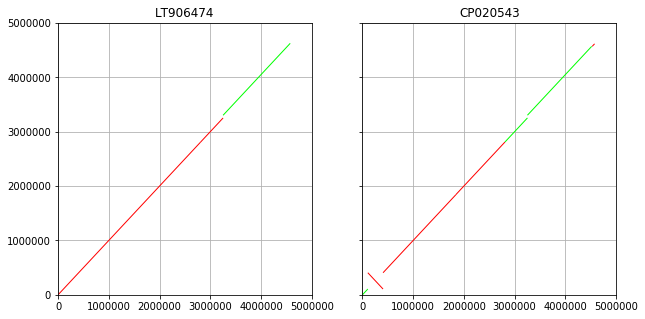

In [15]:
# Here we generate dot plot for four alignemnts

c = np.array([(1, 0, 0, 1), (0, 1, 0, 1)])

fig, ax = pl.subplots( 1,2, figsize=(10, 5), sharey=True, sharex=True )

ax = ax.ravel()

for i, strain in enumerate( strain_data  ):
    lc = mc.LineCollection(strain_data[ strain ], colors=c, linewidths=1)
    ax[i].add_collection(lc)
    ax[i].autoscale()
    ax[i].set_title('%s' % strain )
    ax[i].plot()
    ax[i].set_ylim([0,5000000])
    ax[i].set_xlim([0,5000000])
    ax[i].grid(True)
    ax[i].margins(0.1)
    
pl.show()

Let's look at actual coordinates of alignemnts:

For LT906474:

In [16]:
pysqldf("select q,t,qstart,qend,tstart,tend, tstart-qstart, tend-qend from mb where len > 100000 and t = 'LT906474' order by qstart")

,q,t,qstart,qend,tstart,tend,tstart-qstart,tend-qend
0,1,LT906474,1,2809168,1,2809169,0,1
1,1,LT906474,2809157,3252812,2809125,3252780,-32,-32
2,1,LT906474,3252807,4576293,3302485,4625968,49678,49675


For CP020543:

In [17]:
pysqldf("select q,t,qstart,qend,tstart,tend, tstart-qstart, tend-qend from mb where len > 100000 and t = 'CP020543' order by qstart")

,q,t,qstart,qend,tstart,tend,tstart-qstart,tend-qend
0,1,CP020543,1,106106,49,106154,48,48
1,1,CP020543,106098,406089,406139,106154,300041,-299935
2,1,CP020543,406431,1838776,406140,1838482,-291,-294
3,1,CP020543,1838773,2809168,1839704,2810096,931,928
4,1,CP020543,2809157,3252812,2810052,3253706,895,894
5,1,CP020543,3252807,4519381,3303410,4569981,50603,50600


Last two columns of these tables show the differences between starts and ends of alignemnts within the two genomes. You can see that there is a 49,600 bp deletion in our assembly compared to LT906474 and a 50,600 bp deletion compared with CP020543. You can also see a 30,000 bp inversion between our assembly and CP020543.

## Looking at deleted genes

-------

Our assembly contains a 50 kb deletion. Which genes are contained within this assembly and are they essential? First, we will download annotation files for LT906474 and CP020543. 

NCBI does not make it easy to find relevant information in a readily downloadable form. So here is what needs to be done:

 - Go to [NCBI](https://www.ncbi.nlm.nih.gov/) and enter `LT906474` in the search box at the top
 - You will see a complex page. Look for heading **Genomes** and category *Assembly*. There should be one (1) assembly listed there. Click on [Assembly](https://www.ncbi.nlm.nih.gov/gquery/?term=LT906474)
 - You will see yet another page. At the upper right corner you will see **Assess the data** heading. Click on *Download the RefSeq assembly*. 
 - This will take you to an FTP directory with multiple files. You need the one ending with `feature_table.txt.gz`
 - Right click on it and copy its URL into clipboard.
 - Paste it in the cell below and type `!wget ` in fron of it:

In [18]:
!wget ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/186/905/GCA_900186905.1_49923_G01/GCA_900186905.1_49923_G01_feature_table.txt.gz

--2018-03-02 04:47:25--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/186/905/GCA_900186905.1_49923_G01/GCA_900186905.1_49923_G01_feature_table.txt.gz
           => ‘GCA_900186905.1_49923_G01_feature_table.txt.gz.1’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.229, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.229|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCA/900/186/905/GCA_900186905.1_49923_G01 ... done.
==> SIZE GCA_900186905.1_49923_G01_feature_table.txt.gz ... 177941
==> PASV ... done.    ==> RETR GCA_900186905.1_49923_G01_feature_table.txt.gz ... done.
Length: 177941 (174K) (unauthoritative)

GCA_900186905.1_499 100%[=====================>] 173.77K  --.-KB/s   in 0.1s   

2018-03-02 04:47:27 (1.28 MB/s) - ‘GCA_900186905.1_49923_G01_feature_table.txt.gz.1’ saved [177941]



Similarly for CP020543 we will get:

In [19]:
!wget ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/079/225/GCA_002079225.1_ASM207922v1/GCA_002079225.1_ASM207922v1_feature_table.txt.gz

--2018-03-02 04:47:27--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002/079/225/GCA_002079225.1_ASM207922v1/GCA_002079225.1_ASM207922v1_feature_table.txt.gz
           => ‘GCA_002079225.1_ASM207922v1_feature_table.txt.gz.1’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.229, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.229|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCA/002/079/225/GCA_002079225.1_ASM207922v1 ... done.
==> SIZE GCA_002079225.1_ASM207922v1_feature_table.txt.gz ... 170436
==> PASV ... done.    ==> RETR GCA_002079225.1_ASM207922v1_feature_table.txt.gz ... done.
Length: 170436 (166K) (unauthoritative)

GCA_002079225.1_ASM 100%[=====================>] 166.44K  --.-KB/s   in 0.1s   

2018-03-02 04:47:28 (1.21 MB/s) - ‘GCA_002079225.1_ASM207922v1_feature_table.txt.gz.1’ saved [170436]



Before processing these files let's have a quick look at their content:

In [20]:
!gunzip -c GCA_900186905.1_49923_G01_feature_table.txt.gz | head -n 4

# feature	class	assembly	assembly_unit	seq_type	chromosome	genomic_accession	start	end	strand	product_accession	non-redundant_refseq	related_accession	name	symbol	GeneID	locus_tag	feature_interval_length	product_length	attributes
gene	protein_coding	GCA_900186905.1	Primary Assembly	chromosome	1	LT906474.1	70	1404	+					dnaA		SAMEA4364219_00001	1335		
CDS	with_protein	GCA_900186905.1	Primary Assembly	chromosome	1	LT906474.1	70	1404	+	SNW07074.1			chromosomal replication initiation protein	dnaA		SAMEA4364219_00001	1335	444	
gene	protein_coding	GCA_900186905.1	Primary Assembly	chromosome	1	LT906474.1	1409	2509	+					dnaN		SAMEA4364219_00002	1101		

gzip: stdout: Broken pipe


In [21]:
!gunzip -c GCA_002079225.1_ASM207922v1_feature_table.txt.gz | head -n 4

# feature	class	assembly	assembly_unit	seq_type	chromosome	genomic_accession	start	end	strand	product_accession	non-redundant_refseq	related_accession	name	symbol	GeneID	locus_tag	feature_interval_length	product_length	attributes
gene	protein_coding	GCA_002079225.1	Primary Assembly	chromosome		CP020543.1	49	1452	+					dnaA		B6N50_00005	1404		
CDS	with_protein	GCA_002079225.1	Primary Assembly	chromosome		CP020543.1	49	1452	+	ARE45565.1			chromosomal replication initiator protein DnaA	dnaA		B6N50_00005	1404	467	
gene	protein_coding	GCA_002079225.1	Primary Assembly	chromosome		CP020543.1	1457	2557	+							B6N50_00010	1101		

gzip: stdout: Broken pipe


Let's first upload LT906474 and CP020543 annotations into a dataframes we will call `LT906474` and `CP020543` respectively:

In [22]:
# Read gzipped file in a dataframe
# compression="infer" tells pandas to look at file extension, which is "gz"

LT906474 = pd.read_table("GCA_900186905.1_49923_G01_feature_table.txt.gz", compression="infer")
CP020543 = pd.read_table("GCA_002079225.1_ASM207922v1_feature_table.txt.gz", compression="infer")

In [23]:
LT906474.head()

,# feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
0,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,70,1404,+,NaN,NaN,NaN,NaN,dnaA,NaN,SAMEA4364219_00001,1335,NaN,NaN
1,CDS,with_protein,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,70,1404,+,SNW07074.1,NaN,NaN,chromosomal replication initiation protein,dnaA,NaN,SAMEA4364219_00001,1335,444.0,NaN
2,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,1409,2509,+,NaN,NaN,NaN,NaN,dnaN,NaN,SAMEA4364219_00002,1101,NaN,NaN
3,CDS,with_protein,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,1409,2509,+,SNW07080.1,NaN,NaN,DNA polymerase III,dnaN,NaN,SAMEA4364219_00002,1101,366.0,NaN
4,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,2509,3582,+,NaN,NaN,NaN,NaN,recF,NaN,SAMEA4364219_00003,1074,NaN,NaN


This "`#`" in the "`# feature`" column name is very annoying. We will get rid of it:

In [24]:
LT906474.rename(columns={'# feature':'feature'}, inplace=True)
CP020543.rename(columns={'# feature':'feature'}, inplace=True)

In [25]:
LT906474.head(2)

,feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
0,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,70,1404,+,NaN,NaN,NaN,NaN,dnaA,NaN,SAMEA4364219_00001,1335,NaN,NaN
1,CDS,with_protein,GCA_900186905.1,Primary Assembly,chromosome,1,LT906474.1,70,1404,+,SNW07074.1,NaN,NaN,chromosomal replication initiation protein,dnaA,NaN,SAMEA4364219_00001,1335,444.0,NaN


Now let's combine `LT906474` and `CP020543` dataframes into a single dataframe we will call `genes`:

In [26]:
genes = pd.concat( [ LT906474,CP020543 ] )

In [27]:
genes.head()

,feature,class,assembly,assembly_unit,seq_type,chromosome,genomic_accession,start,end,strand,product_accession,non-redundant_refseq,related_accession,name,symbol,GeneID,locus_tag,feature_interval_length,product_length,attributes
0,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1.0,LT906474.1,70,1404,+,NaN,NaN,NaN,NaN,dnaA,NaN,SAMEA4364219_00001,1335,NaN,NaN
1,CDS,with_protein,GCA_900186905.1,Primary Assembly,chromosome,1.0,LT906474.1,70,1404,+,SNW07074.1,NaN,NaN,chromosomal replication initiation protein,dnaA,NaN,SAMEA4364219_00001,1335,444.0,NaN
2,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1.0,LT906474.1,1409,2509,+,NaN,NaN,NaN,NaN,dnaN,NaN,SAMEA4364219_00002,1101,NaN,NaN
3,CDS,with_protein,GCA_900186905.1,Primary Assembly,chromosome,1.0,LT906474.1,1409,2509,+,SNW07080.1,NaN,NaN,DNA polymerase III,dnaN,NaN,SAMEA4364219_00002,1101,366.0,NaN
4,gene,protein_coding,GCA_900186905.1,Primary Assembly,chromosome,1.0,LT906474.1,2509,3582,+,NaN,NaN,NaN,NaN,recF,NaN,SAMEA4364219_00003,1074,NaN,NaN


We only really need rows with `gene` in them, so let's remove all rows where feature is `CDS` and only retain certain columns:

In [28]:
genes = pysqldf("select genomic_accession, symbol, name, start, end, strand, attributes from genes where feature != 'CDS'")

In [29]:
genes.head()

,genomic_accession,symbol,name,start,end,strand,attributes
0,LT906474.1,dnaA,None,70,1404,+,None
1,LT906474.1,dnaN,None,1409,2509,+,None
2,LT906474.1,recF,None,2509,3582,+,None
3,LT906474.1,gyrB,None,3611,6025,+,None
4,LT906474.1,yidB,None,6265,6663,+,None


From our analysis above we know that the region deleted in our assembly corresponds to LT906474 genomic positions 3252780-3302485 and CP020543 genomic positions 3253706-3303410. Which genes are located in this region. For LT906474 we get:

In [30]:
pysqldf("select * from genes where genomic_accession = 'LT906474.1' and start > 3252780 and end < 3302485")

,genomic_accession,symbol,name,start,end,strand,attributes
0,LT906474.1,cstA,None,3253144,3255249,-,None
1,LT906474.1,entH,None,3255430,3255843,-,None
2,LT906474.1,entA,None,3255846,3256592,-,None
3,LT906474.1,entB,None,3256592,3257449,-,None
4,LT906474.1,entE,None,3257463,3259073,-,None
5,LT906474.1,entC,None,3259083,3260258,-,None
6,LT906474.1,fepB,None,3260633,3261589,+,None
7,LT906474.1,entS,None,3261593,3262843,-,None
8,LT906474.1,fepD,None,3262954,3263958,+,None
9,LT906474.1,fepG,None,3263955,3264947,+,None


In [31]:
pysqldf("select * from genes where genomic_accession = 'CP020543.1' and start > 3253706 and end < 3303410")

,genomic_accession,symbol,name,start,end,strand,attributes
0,CP020543.1,None,None,3254070,3256175,-,None
1,CP020543.1,None,None,3256356,3256769,-,None
2,CP020543.1,None,None,3256772,3257518,-,None
3,CP020543.1,None,None,3257518,3258375,-,None
4,CP020543.1,entE,None,3258389,3259999,-,None
5,CP020543.1,None,None,3260009,3261184,-,None
6,CP020543.1,None,None,3261349,3261555,+,None
7,CP020543.1,None,None,3261559,3262515,+,None
8,CP020543.1,None,None,3262519,3263769,-,None
9,CP020543.1,None,None,3263880,3264884,+,None


You will see that LT906474 contains better annotation - most genes contain standard symbols (`symbol` field). Thus let's use LT906474 annotation for further analysis.

## Are there any essential genes among deleted ones?

------

[Goodall et al. (2018)](http://mbio.asm.org/content/9/1/e02096-17) have recently published a list of essential genes for *E. coli* K-12. We can use thier data to answer this question. This paper contains a supplemntary file in excel format, which we can read directly:


In [32]:
essential_genes = pd.read_excel("http://mbio.asm.org/content/9/1/e02096-17/DC7/embed/inline-supplementary-material-7.xlsx", header=1)

In [33]:
essential_genes.head()

,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear
0,thrL,0.242424,54.626410,False,True,False
1,thrA,0.149817,32.642621,False,True,False
2,thrB,0.177921,39.389847,False,True,False
3,thrC,0.149184,32.489551,False,True,False
4,yaaX,0.161616,35.485996,False,True,False


Now we can join this dataframe with `genes` dataframe we've created earlier:

In [34]:
pysqldf("select * from genes left join essential_genes on genes.symbol = essential_genes.Gene where genomic_accession = 'LT906474.1' and start > 3252780 and end < 3302485")

,genomic_accession,symbol,name,start,end,strand,attributes,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear
0,LT906474.1,cstA,None,3253144,3255249,-,None,cstA,0.126306,26.919065,0.0,1.0,0.0
1,LT906474.1,entH,None,3255430,3255843,-,None,entH,0.120773,25.558626,0.0,1.0,0.0
2,LT906474.1,entA,None,3255846,3256592,-,None,entA,0.104418,21.498726,0.0,1.0,0.0
3,LT906474.1,entB,None,3256592,3257449,-,None,entB,0.088578,17.497706,0.0,1.0,0.0
4,LT906474.1,entE,None,3257463,3259073,-,None,entE,0.105525,21.775523,0.0,1.0,0.0
5,LT906474.1,entC,None,3259083,3260258,-,None,entC,0.102891,21.116439,0.0,1.0,0.0
6,LT906474.1,fepB,None,3260633,3261589,+,None,fepB,0.056426,9.033369,0.0,1.0,0.0
7,LT906474.1,entS,None,3261593,3262843,-,None,entS,0.108713,22.571116,0.0,1.0,0.0
8,LT906474.1,fepD,None,3262954,3263958,+,None,fepD,0.058706,9.656014,0.0,1.0,0.0
9,LT906474.1,fepG,None,3263955,3264947,+,None,fepG,0.057402,9.300311,0.0,1.0,0.0


All values within `Essential` column are either `0` or `NaN`. Thus no essential genes are contained within the region deleted from our assembly. 

# The end!